In [29]:
import os

folder = "models"
mode_version = "png_nine_spec_arr_smote_v1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/png_nine_spec_arr_smote_v1


In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [5]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel
import cv2

<h2>Data Loading and Preparation</h2>

In [6]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    elif x == 8:
        return 'No_Bat'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted



# Ytrain in Onehot encoded form 
def makeOverSamplesSMOTE(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original trainingset shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    sm = SMOTE(sampling_strategy='all',k_neighbors=5)
    X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=9)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [22]:
X_all = np.load('../../../data/MEL_all_PLT_NMP_X.npy', allow_pickle= True)
Y_all =  np.load('../../../data/MEL_all_PLT_NMP_Y.npy', allow_pickle= True)

print(X_all.shape)
print(Y_all.shape)



Y_all = np_utils.to_categorical(Y_all, num_classes=9) 


(3426, 288, 432, 3)
(3426,)


In [23]:
import copy
new_X = []

for x in X_all:
    cp_x =  copy.deepcopy(x)
    cp_x = cv2.resize(cp_x,dsize=(170,112))
    new_X.append(cp_x)
    
new_X = np.array(new_X)
print(new_X.shape)
X_all = new_X
X_all = X_all.astype('float32')
X_all /= 255

(3426, 112, 170, 3)


In [24]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2> Training and Save</h2>

In [30]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(9, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [31]:
model = build_current_model()
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_30 (Batc (None, 56, 85, 56)        224       
_________________________________________________________________
activation_30 (Activation)   (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 43, 56)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 22, 72)        1008

In [32]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=9

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1


    
    
    

In [33]:
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
   
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    
    
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
   
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1




Original trainingset shape [('R.muscatellum', 1198), ('P.kuhli', 215), ('R.aegyptius', 87), ('T.perforatus', 290), ('E.bottae', 90), ('M.emarginatus', 81), ('No_Bat', 293), ('A.tridens', 18), ('R.nasutus', 194)]
Resampled training set shape [('R.muscatellum', 1198), ('P.kuhli', 1198), ('R.aegyptius', 1198), ('T.perforatus', 1198), ('E.bottae', 1198), ('M.emarginatus', 1198), ('No_Bat', 1198), ('A.tridens', 1198), ('R.nasutus', 1198)]
After OverSampling
X_train: shape=  (10782, 112, 170, 3)
Y_train: shape=  (10782, 9)
Train on 10782 samples, validate on 617 samples
Epoch 1/100
10782/10782 - 7s - loss: 1.6190 - accuracy: 0.4039 - val_loss: 1.0547 - val_accuracy: 0.6386
Epoch 2/100
10782/10782 - 7s - loss: 0.9468 - accuracy: 0.6723 - val_loss: 0.9260 - val_accuracy: 0.7002
Epoch 3/100
10782/10782 - 7s - loss: 0.5965 - accuracy: 0.7982 - val_loss: 0.5963 - val_accuracy: 0.7812
Epoch 4/100
10782/10782 - 7s - loss: 0.4462 - accuracy: 0.8490 - val_loss: 0.5887 - val_accuracy: 0.8071
Epoch 5/1

INFO:tensorflow:Assets written to: models/png_nine_spec_arr_smote_v1_iter_1.model/assets
Original trainingset shape [('R.muscatellum', 1198), ('P.kuhli', 215), ('R.aegyptius', 87), ('T.perforatus', 290), ('E.bottae', 90), ('M.emarginatus', 81), ('No_Bat', 293), ('A.tridens', 18), ('R.nasutus', 194)]
Resampled training set shape [('R.muscatellum', 1198), ('P.kuhli', 1198), ('R.aegyptius', 1198), ('T.perforatus', 1198), ('E.bottae', 1198), ('M.emarginatus', 1198), ('No_Bat', 1198), ('A.tridens', 1198), ('R.nasutus', 1198)]
After OverSampling
X_train: shape=  (10782, 112, 170, 3)
Y_train: shape=  (10782, 9)
Train on 10782 samples, validate on 617 samples
Epoch 1/100
10782/10782 - 7s - loss: 1.6397 - accuracy: 0.3961 - val_loss: 1.0326 - val_accuracy: 0.5997
Epoch 2/100
10782/10782 - 8s - loss: 0.9907 - accuracy: 0.6461 - val_loss: 0.8632 - val_accuracy: 0.6872
Epoch 3/100
10782/10782 - 7s - loss: 0.6185 - accuracy: 0.7888 - val_loss: 0.5445 - val_accuracy: 0.7763
Epoch 4/100
10782/10782 -

Epoch 73/100
Restoring model weights from the end of the best epoch.
10782/10782 - 7s - loss: 0.0670 - accuracy: 0.9784 - val_loss: 0.3871 - val_accuracy: 0.8930
Epoch 00073: early stopping
models/png_nine_spec_arr_smote_v1_iter_2.model
INFO:tensorflow:Assets written to: models/png_nine_spec_arr_smote_v1_iter_2.model/assets
Original trainingset shape [('R.muscatellum', 1198), ('P.kuhli', 215), ('R.aegyptius', 86), ('T.perforatus', 290), ('E.bottae', 90), ('M.emarginatus', 81), ('No_Bat', 294), ('A.tridens', 18), ('R.nasutus', 194)]
Resampled training set shape [('R.muscatellum', 1198), ('P.kuhli', 1198), ('R.aegyptius', 1198), ('T.perforatus', 1198), ('E.bottae', 1198), ('M.emarginatus', 1198), ('No_Bat', 1198), ('A.tridens', 1198), ('R.nasutus', 1198)]
After OverSampling
X_train: shape=  (10782, 112, 170, 3)
Y_train: shape=  (10782, 9)
Train on 10782 samples, validate on 617 samples
Epoch 1/100
10782/10782 - 7s - loss: 1.5559 - accuracy: 0.4313 - val_loss: 1.5180 - val_accuracy: 0.500

Epoch 17/100
10791/10791 - 7s - loss: 0.1799 - accuracy: 0.9387 - val_loss: 0.3468 - val_accuracy: 0.8752
Epoch 18/100
10791/10791 - 8s - loss: 0.1784 - accuracy: 0.9386 - val_loss: 0.2923 - val_accuracy: 0.8914
Epoch 19/100
10791/10791 - 8s - loss: 0.1841 - accuracy: 0.9382 - val_loss: 0.3139 - val_accuracy: 0.8914
Epoch 20/100
10791/10791 - 7s - loss: 0.1641 - accuracy: 0.9418 - val_loss: 0.3392 - val_accuracy: 0.8817
Epoch 21/100
10791/10791 - 7s - loss: 0.1589 - accuracy: 0.9458 - val_loss: 0.2964 - val_accuracy: 0.8979
Epoch 22/100
10791/10791 - 7s - loss: 0.1582 - accuracy: 0.9458 - val_loss: 0.3264 - val_accuracy: 0.8768
Epoch 23/100
10791/10791 - 7s - loss: 0.1524 - accuracy: 0.9507 - val_loss: 0.3398 - val_accuracy: 0.8930
Epoch 24/100
10791/10791 - 8s - loss: 0.1367 - accuracy: 0.9546 - val_loss: 0.4296 - val_accuracy: 0.8801
Epoch 25/100
10791/10791 - 7s - loss: 0.1529 - accuracy: 0.9484 - val_loss: 0.4091 - val_accuracy: 0.8833
Epoch 26/100
10791/10791 - 7s - loss: 0.1476 -

Epoch 27/100
10791/10791 - 7s - loss: 0.1431 - accuracy: 0.9513 - val_loss: 0.3875 - val_accuracy: 0.8930
Epoch 28/100
10791/10791 - 7s - loss: 0.1337 - accuracy: 0.9563 - val_loss: 0.3425 - val_accuracy: 0.8801
Epoch 29/100
10791/10791 - 8s - loss: 0.1384 - accuracy: 0.9551 - val_loss: 0.4007 - val_accuracy: 0.8882
Epoch 30/100
10791/10791 - 7s - loss: 0.1223 - accuracy: 0.9606 - val_loss: 0.4090 - val_accuracy: 0.8784
Epoch 31/100
10791/10791 - 8s - loss: 0.1291 - accuracy: 0.9543 - val_loss: 0.3519 - val_accuracy: 0.8947
Epoch 32/100
10791/10791 - 7s - loss: 0.1250 - accuracy: 0.9577 - val_loss: 0.4460 - val_accuracy: 0.8947
Epoch 33/100
10791/10791 - 8s - loss: 0.1181 - accuracy: 0.9600 - val_loss: 0.3947 - val_accuracy: 0.8736
Epoch 34/100
10791/10791 - 8s - loss: 0.1219 - accuracy: 0.9603 - val_loss: 0.3824 - val_accuracy: 0.8930
Epoch 35/100
10791/10791 - 7s - loss: 0.1252 - accuracy: 0.9577 - val_loss: 0.3705 - val_accuracy: 0.8882
Epoch 36/100
10791/10791 - 8s - loss: 0.1234 -

Epoch 55/100
10791/10791 - 7s - loss: 0.0902 - accuracy: 0.9696 - val_loss: 0.4159 - val_accuracy: 0.9044
Epoch 56/100
10791/10791 - 7s - loss: 0.0857 - accuracy: 0.9709 - val_loss: 0.4092 - val_accuracy: 0.9011
Epoch 57/100
10791/10791 - 7s - loss: 0.1001 - accuracy: 0.9650 - val_loss: 0.3903 - val_accuracy: 0.8963
Epoch 58/100
Restoring model weights from the end of the best epoch.
10791/10791 - 7s - loss: 0.0863 - accuracy: 0.9728 - val_loss: 0.3672 - val_accuracy: 0.8979
Epoch 00058: early stopping
models/png_nine_spec_arr_smote_v1_iter_6.model
INFO:tensorflow:Assets written to: models/png_nine_spec_arr_smote_v1_iter_6.model/assets
Original trainingset shape [('No_Bat', 294), ('T.perforatus', 290), ('R.aegyptius', 87), ('R.muscatellum', 1199), ('P.kuhli', 215), ('R.nasutus', 194), ('E.bottae', 89), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('No_Bat', 1199), ('T.perforatus', 1199), ('R.aegyptius', 1199), ('R.muscatellum', 1199), ('P.kuhli', 1199), ('R.n

Epoch 7/100
10791/10791 - 7s - loss: 0.3236 - accuracy: 0.8932 - val_loss: 0.4146 - val_accuracy: 0.8558
Epoch 8/100
10791/10791 - 7s - loss: 0.2944 - accuracy: 0.9025 - val_loss: 0.3432 - val_accuracy: 0.8801
Epoch 9/100
10791/10791 - 7s - loss: 0.2805 - accuracy: 0.9036 - val_loss: 0.3606 - val_accuracy: 0.8784
Epoch 10/100
10791/10791 - 7s - loss: 0.2628 - accuracy: 0.9117 - val_loss: 0.3706 - val_accuracy: 0.8979
Epoch 11/100
10791/10791 - 7s - loss: 0.2421 - accuracy: 0.9149 - val_loss: 0.3562 - val_accuracy: 0.8833
Epoch 12/100
10791/10791 - 8s - loss: 0.2319 - accuracy: 0.9202 - val_loss: 0.3522 - val_accuracy: 0.8979
Epoch 13/100
10791/10791 - 7s - loss: 0.2244 - accuracy: 0.9234 - val_loss: 0.3998 - val_accuracy: 0.8833
Epoch 14/100
10791/10791 - 7s - loss: 0.2137 - accuracy: 0.9273 - val_loss: 0.3626 - val_accuracy: 0.8947
Epoch 15/100
10791/10791 - 7s - loss: 0.2019 - accuracy: 0.9320 - val_loss: 0.3564 - val_accuracy: 0.8947
Epoch 16/100
10791/10791 - 7s - loss: 0.1974 - ac

Epoch 38/100
Restoring model weights from the end of the best epoch.
10782/10782 - 7s - loss: 0.1152 - accuracy: 0.9596 - val_loss: 0.3590 - val_accuracy: 0.9044
Epoch 00038: early stopping
models/png_nine_spec_arr_smote_v1_iter_9.model
INFO:tensorflow:Assets written to: models/png_nine_spec_arr_smote_v1_iter_9.model/assets
Original trainingset shape [('No_Bat', 294), ('T.perforatus', 290), ('R.aegyptius', 87), ('R.muscatellum', 1198), ('P.kuhli', 215), ('R.nasutus', 194), ('E.bottae', 90), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('No_Bat', 1198), ('T.perforatus', 1198), ('R.aegyptius', 1198), ('R.muscatellum', 1198), ('P.kuhli', 1198), ('R.nasutus', 1198), ('E.bottae', 1198), ('A.tridens', 1198), ('M.emarginatus', 1198)]
After OverSampling
X_train: shape=  (10782, 112, 170, 3)
Y_train: shape=  (10782, 9)
Train on 10782 samples, validate on 617 samples
Epoch 1/100
10782/10782 - 8s - loss: 1.6295 - accuracy: 0.4057 - val_loss: 1.1009 - val_accuracy: 0.609

# Load and Evaluate

In [34]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=9


In [35]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    print('File Name Loaded: ',model_file)
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus','No_Bat']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_1.model
File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_2.model
File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_3.model
File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_4.model
File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_5.model
File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_6.model
File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_7.model
File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_8.model
File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_9.model
File Name Loaded:  models/png_nine_spec_arr_smote_v1_iter_10.model


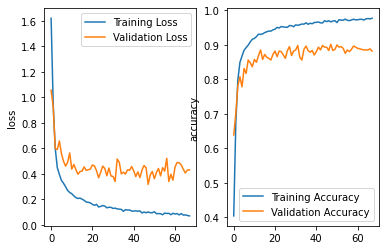

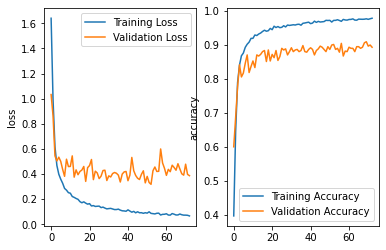

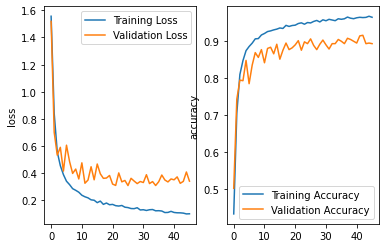

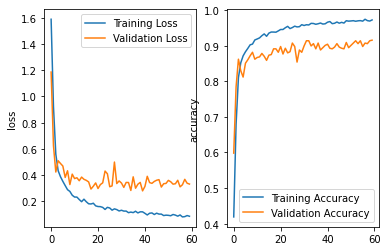

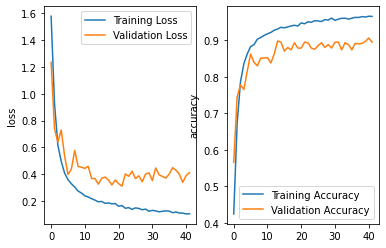

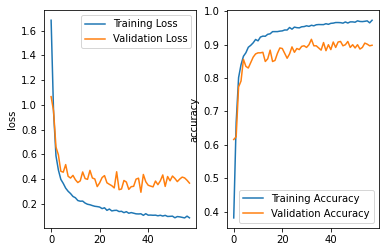

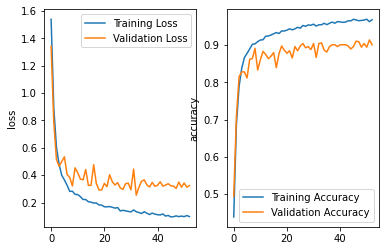

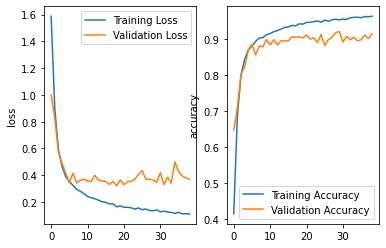

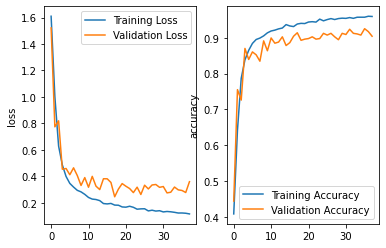

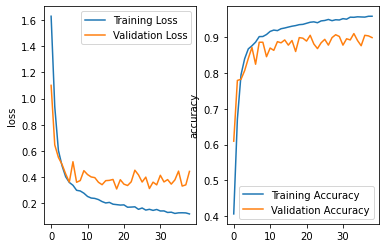

In [36]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [37]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.9209707  0.81443556 0.90944656 0.96621395 0.94881355
 0.83289404 0.8841508  0.65729385]
precision sdev by class [0.         0.07229099 0.09184425 0.05675336 0.01216888 0.03498289
 0.10839767 0.03541516 0.09663099]
macro precision mean 0.8815798903374231
macro precision sdev 0.029867315556001105
recall mean [0.91666667 0.96025641 0.84924242 0.96321839 0.93756944 0.93276353
 0.91666667 0.89567073 0.64932927]
recall sdev [0.17078251 0.05261099 0.053187   0.02331946 0.02902872 0.04728315
 0.0745356  0.04979841 0.11936665]
macro recall mean 0.8912648367594092
macro recall sdev 0.02133031221619467
f1 mean [0.94666667 0.93829564 0.82846245 0.93454034 0.95137472 0.93963562
 0.87017625 0.88871396 0.64333276]
f1 sdev [0.11075498 0.04869415 0.05551335 0.03246341 0.01497095 0.02767838
 0.08543819 0.0291407  0.07609315]
macro f1 mean 0.8823553795072077
macro f1 sdev 0.02134402922780611
accuracy mean 0.8972516324825671
accuracy sdev 0.019589857576635655


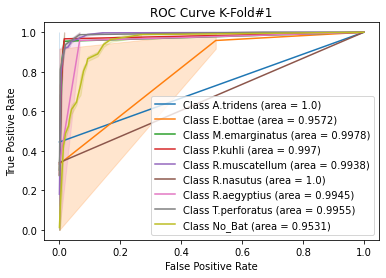

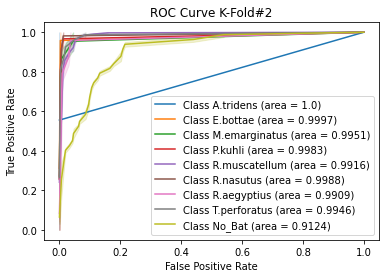

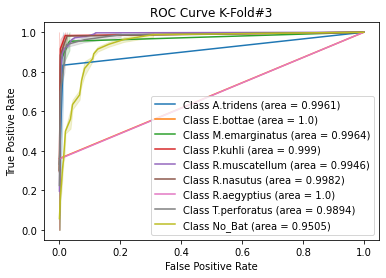

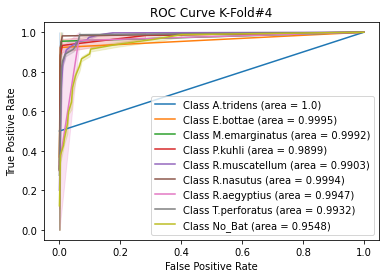

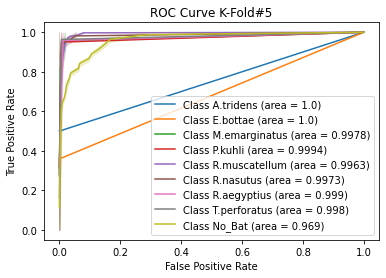

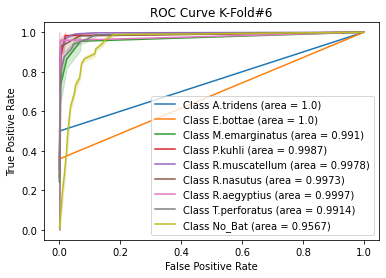

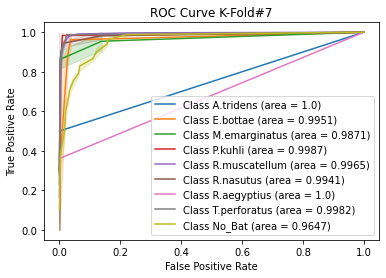

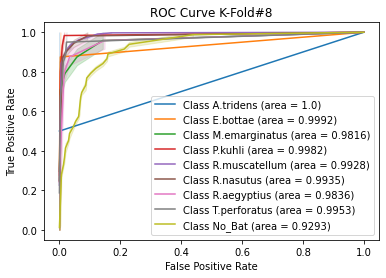

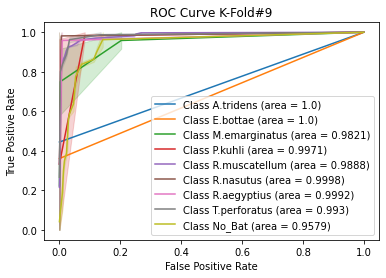

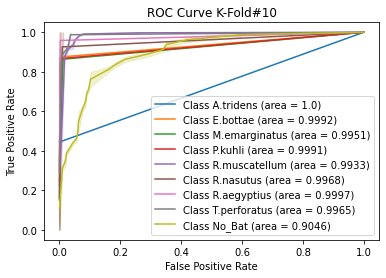

In [38]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [39]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  0.9996078431372549
Std  0.00117647058823529
Sp:  E.bottae
AUC Mean  0.9950057304868644
Std  0.01268035783241186
Sp:  M.emarginatus
AUC Mean  0.9923056852513046
Std  0.006238741082930332
Sp:  P.kuhli
AUC Mean  0.9975504244785119
Std  0.002664305812054833
Sp:  R.muscatellum
AUC Mean  0.9935627322750149
Std  0.0026966673258646697
Sp:  R.nasutus
AUC Mean  0.9975275060789531
Std  0.0021200273652397248
Sp:  R.aegyptius
AUC Mean  0.996142772132198
Std  0.005129655596436332
Sp:  T.perforatus
AUC Mean  0.9945040295904894
Std  0.002679539276620903
Sp:  No_Bat
AUC Mean  0.9453008761512667
Std  0.02096692723939848


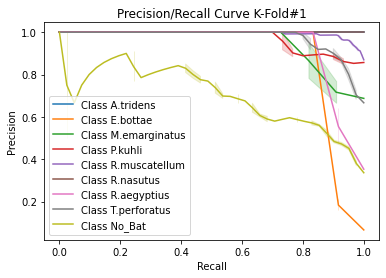

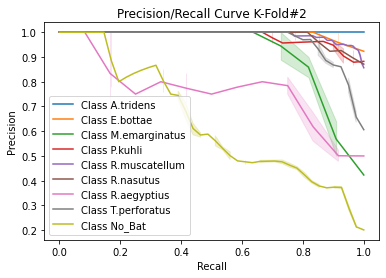

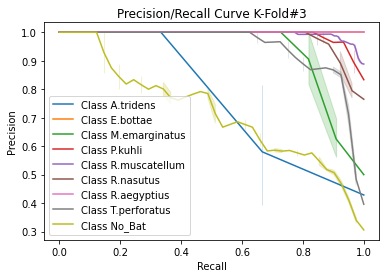

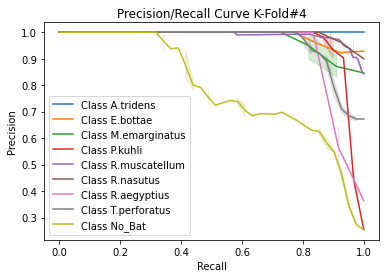

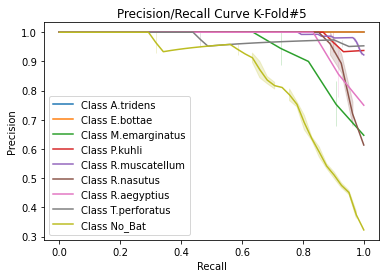

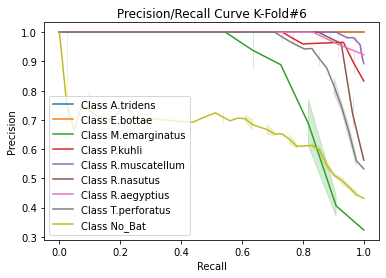

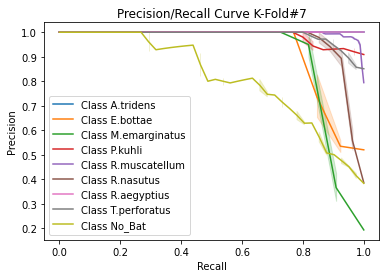

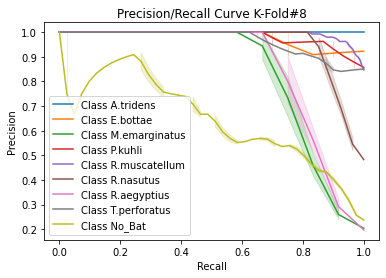

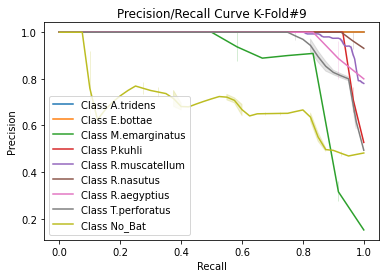

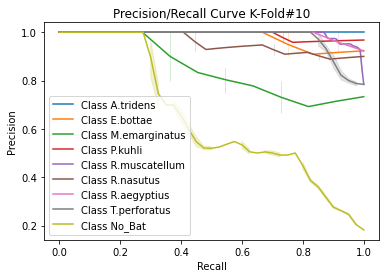

In [40]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  3   0   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0   1]
 [  0   0   9   1   0   0   0   0   1]
 [  0   0   0  28   0   0   0   0   2]
 [  0   0   0   0 160   0   0   0   7]
 [  0   0   0   0   0  25   0   0   2]
 [  0   0   0   0   0   0  11   0   1]
 [  0   0   0   1   2   0   1  33   3]
 [  0   0   2   3   6   0   0   3  27]]


Confusion Matrix K-Fold #2

[[  3   0   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0   0]
 [  0   0  10   0   1   0   0   0   0]
 [  0   0   0  28   0   1   0   0   1]
 [  0   1   1   0 153   0   0   1  11]
 [  0   0   0   0   0  26   1   0   0]
 [  0   0   1   0   1   0  10   0   0]
 [  0   0   0   0   0   0   0  36   4]
 [  0   1   0   2   6   1   6   4  21]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0   1]
 [  0  12   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   1]
 [  0   0   0  29   0   1   0   0   0]
 [  0   0   0   0 154   0   0   2  11]
 [  0   0   1

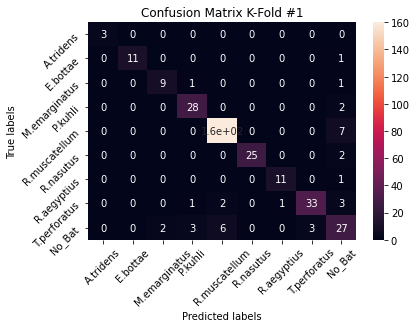

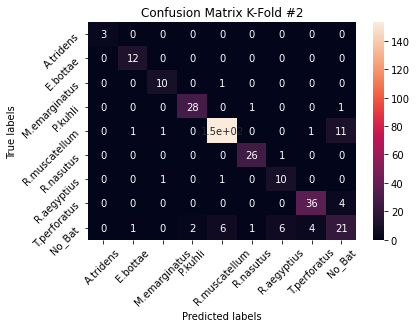

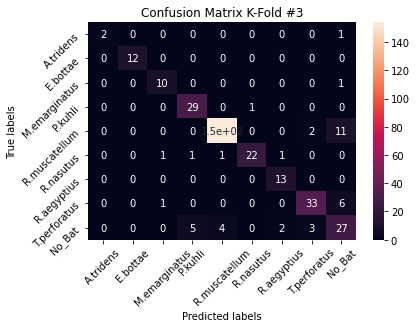

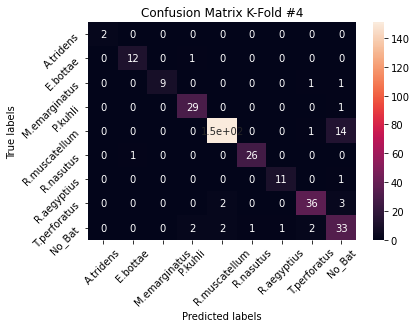

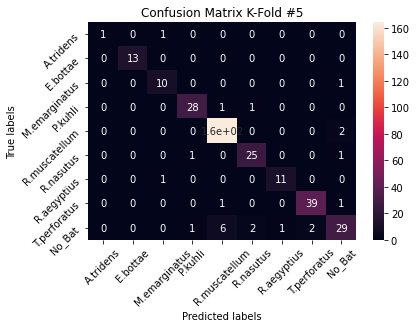

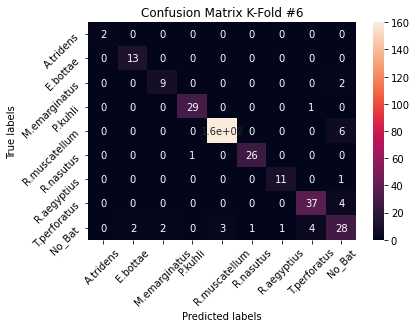

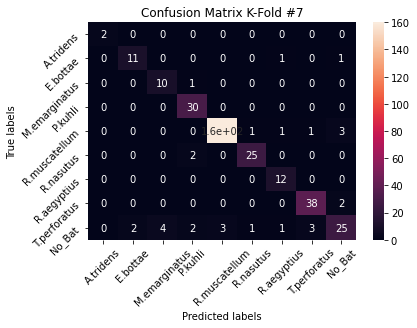

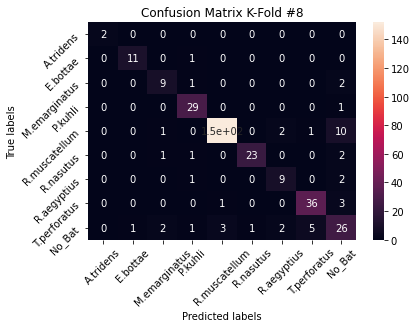

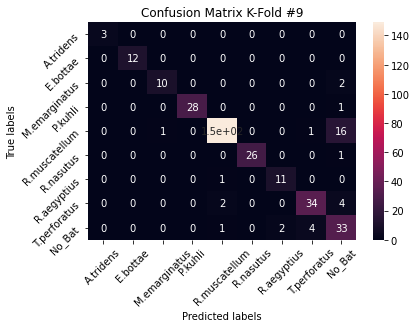

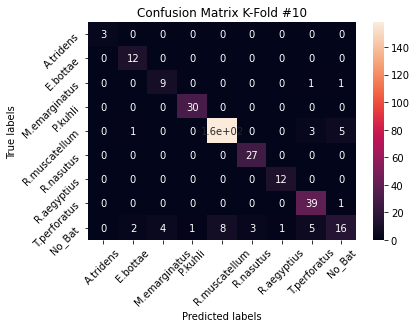

In [41]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    1    0    0    0    0    0    1]
 [   0  119    0    2    0    0    1    0    2]
 [   0    0   95    3    1    0    0    2   11]
 [   0    0    0  288    1    3    0    1    6]
 [   0    2    3    0 1561    1    3   10   85]
 [   0    1    2    6    1  251    2    0    6]
 [   0    0    2    1    2    0  111    0    5]
 [   0    0    1    1    8    0    1  361   31]
 [   0    8   14   17   42   10   17   35  265]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0   1]
 [  0   0   0  28   0   0   0   0   0]
 [  0   0   0   0 156   0   0   1   8]
 [  0   0   0   0   0  25   0   0   0]
 [  0   0   0   0   0   0  11   0   0]
 [  0   0   0   0   0   0   0  36   3]
 [  0   0   1   1   4   1   1   3  26]]


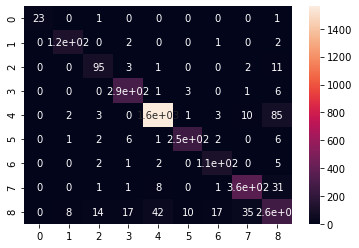

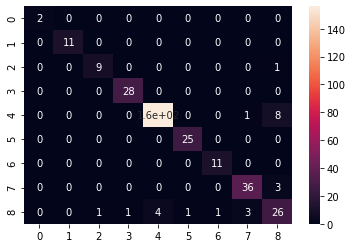

In [42]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.04 0.   0.   0.   0.   0.   0.04]
 [0.   0.96 0.   0.02 0.   0.   0.01 0.   0.02]
 [0.   0.   0.85 0.03 0.01 0.   0.   0.02 0.1 ]
 [0.   0.   0.   0.96 0.   0.01 0.   0.   0.02]
 [0.   0.   0.   0.   0.94 0.   0.   0.01 0.05]
 [0.   0.   0.01 0.02 0.   0.93 0.01 0.   0.02]
 [0.   0.   0.02 0.01 0.02 0.   0.92 0.   0.04]
 [0.   0.   0.   0.   0.02 0.   0.   0.9  0.08]
 [0.   0.02 0.03 0.04 0.1  0.02 0.04 0.09 0.65]]


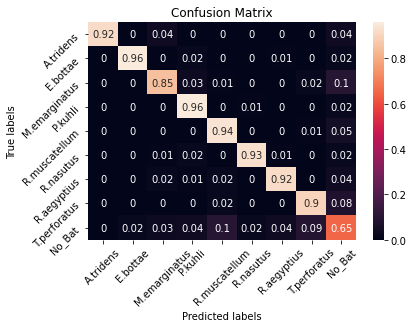

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus','No_Bat']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);